## **Pre-Trained BERT and Fine Tuning implement ** by Pouria Zarrehparvar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf
import warnings
import tensorflow_hub as hub

warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

path = "/content/drive/MyDrive/cleanDataf.csv"
data = pd.read_csv(path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], random_state=0)

In [ ]:
!pip install tensorflow-text
import tensorflow_text as text

In [ ]:
!pip install --quiet transformers
from transformers import TFBertModel, BertTokenizer
import tensorflow_hub as hub

     |████████████████████████████████| 4.7 MB 25.4 MB/s 
     |████████████████████████████████| 6.6 MB 59.4 MB/s 
     |████████████████████████████████| 120 kB 73.9 MB/s 


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


In [ ]:
preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# Step 1: tokenize batches of text inputs.
text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# Step 2 (optional): modify tokenized inputs.
pass

# Step 3: pack input sequences for the Transformer encoder.
seq_length = 300
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)


In [ ]:
outputs = bert_encoder(encoder_inputs)

In [ ]:
l = tf.keras.layers.Dropout(0.1)(outputs['pooled_output'])

l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
model = tf.keras.Model(inputs=text_inputs, outputs = [l])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_3 (KerasLayer)     {'input_type_ids':   0           ['keras_layer_2[0][0]']          
                                (None, 300),                                                      
                                 'input_word_ids':                                                
                                (None, 300),                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),
 loss='binary_crossentropy',
 metrics=METRICS)



In [ ]:
history_model_BERT = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=128)

Epoch 1/10
185/185 [==============================] - 963s 5s/step - loss: 0.4066 - accuracy: 0.8236 - val_loss: 0.2996 - val_accuracy: 0.8751
Epoch 2/10
185/185 [==============================] - 960s 5s/step - loss: 0.2961 - accuracy: 0.8760 - val_loss: 0.2715 - val_accuracy: 0.8852
Epoch 3/10
185/185 [==============================] - 961s 5s/step - loss: 0.2797 - accuracy: 0.8846 - val_loss: 0.2857 - val_accuracy: 0.8735
Epoch 4/10
185/185 [==============================] - 961s 5s/step - loss: 0.2711 - accuracy: 0.8871 - val_loss: 0.3379 - val_accuracy: 0.8556
Epoch 5/10
185/185 [==============================] - 960s 5s/step - loss: 0.2644 - accuracy: 0.8884 - val_loss: 0.2329 - val_accuracy: 0.9052
Epoch 6/10
185/185 [==============================] - 961s 5s/step - loss: 0.2610 - accuracy: 0.8943 - val_loss: 0.2289 - val_accuracy: 0.9072
Epoch 7/10
185/185 [==============================] - 959s 5s/step - loss: 0.2585 - accuracy: 0.8918 - val_loss: 0.2258 - val_accuracy: 0.9103

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 838s 796ms/step - loss: 0.2186 - accuracy: 0.9125
Accuracy of the model on Training Data is -  91.25115275382996 %
351/351 [==============================] - 280s 799ms/step - loss: 0.2226 - accuracy: 0.9060
Accuracy of the model on Testing Data is -  90.60133695602417 %


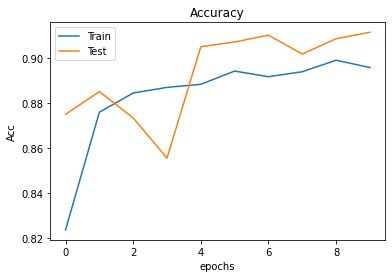

In [ ]:
plt.figure()
plt.plot(history_model_BERT.history["accuracy"], label = "Train")
plt.plot(history_model_BERT.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

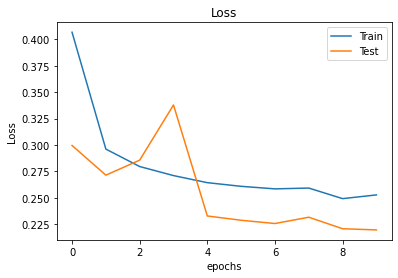

In [ ]:
plt.figure()
plt.plot(history_model_BERT.history["loss"], label = "Train")
plt.plot(history_model_BERT.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()


In [ ]:
pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))


351/351 [==============================] - 275s 785ms/step
              precision    recall  f1-score   support

        Fake       0.92      0.90      0.91      5858
        Real       0.89      0.92      0.90      5367

    accuracy                           0.91     11225
   macro avg       0.91      0.91      0.91     11225
weighted avg       0.91      0.91      0.91     11225



Text(42.0, 0.5, 'Actual')

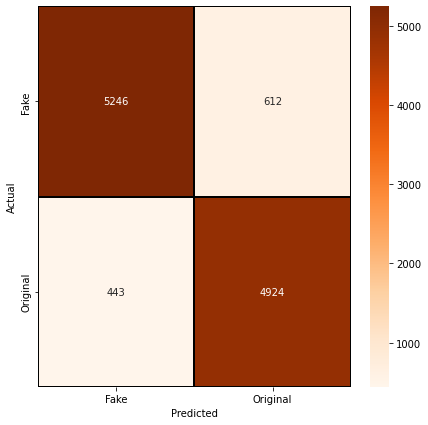

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
